# Generating useful features for further analysis on Amazon reviews

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly
import seaborn as sns
nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 10000 reviews by using 'chunksize'. All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=10000))
# If your computer has enough memory, uncomment the line below to use the entire dataset.
# movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 2.17 s, sys: 557 ms, total: 2.73 s
Wall time: 11.5 s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [3]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [4]:
print(len(movies_tv))
print(movies_tv.head(5))

10000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      12

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [5]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

CPU times: user 125 ms, sys: 693 µs, total: 125 ms
Wall time: 585 ms


In [6]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1:

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

**Answer.**

<AxesSubplot:xlabel='Count', ylabel='overall'>

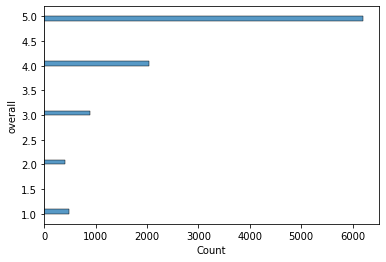

In [7]:
sns.histplot(data=movies_tv, y='overall')

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

**Answer.**

<AxesSubplot:xlabel='year', ylabel='overall'>

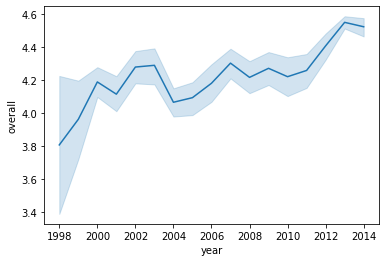

In [8]:
movies_tv["year"] = movies_tv.datetime.dt.year
movies_tv.groupby(['year']).mean()
sns.lineplot(data=movies_tv, x="year", y="overall")

There is an increase in the mean of the reviews,the overall mean increased from 3.8 in 1998 to 4.5 in 2014

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

<AxesSubplot:xlabel='datetime'>

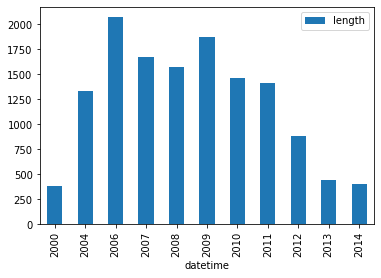

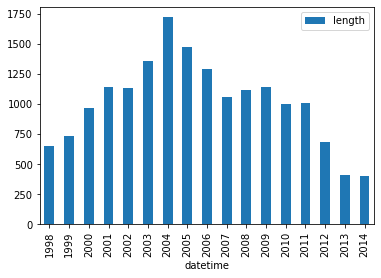

In [9]:
instant_video['length'] = instant_video['reviewText'].apply(len)
instant_video.groupby(instant_video.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

movies_tv['length'] = movies_tv['reviewText'].apply(len)
movies_tv.groupby(movies_tv.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

**Answer.**

Eventough the mean of the reviews has increased the amount of reviews has decreased, this could mean that the overall reviews aren't better as suggestes by the previous graph, but instead only the people that like the movie review and we could be missing the real perception of the movie.

### Exercise 2:

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

**Answer.**

In [10]:
nltk.download('stopwords')
negative_reviews=movies_tv[movies_tv['overall']<=2]
positive_reviews=movies_tv[movies_tv['overall']>2]

negative_text=''.join(negative_reviews['reviewText'])
positive_text=''.join(positive_reviews['reviewText'])
all_text=''.join(movies_tv['reviewText'])

stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('i')

allWords = nltk.tokenize.word_tokenize(all_text)
negWords = nltk.tokenize.word_tokenize(negative_text)
posWords = nltk.tokenize.word_tokenize(positive_text)

allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords if w.isalnum())
negWordExceptStopDist = nltk.FreqDist(w.lower() for w in negWords if w not in stopwords if w.isalnum())
posWordExceptStopDist = nltk.FreqDist(w.lower() for w in posWords if w not in stopwords if w.isalnum())
print('all')
print(allWordExceptStopDist.most_common(10))
print('negative')
print(negWordExceptStopDist.most_common(10))
print('positive')
print(posWordExceptStopDist.most_common(10))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


all
[('i', 21800), ('movie', 12791), ('the', 11653), ('film', 10230), ('one', 7617), ('it', 5043), ('like', 4642), ('great', 4109), ('quot', 4106), ('good', 4033)]
negative
[('i', 2631), ('movie', 1324), ('the', 1044), ('film', 1023), ('one', 640), ('like', 572), ('would', 530), ('jesus', 465), ('it', 459), ('quot', 393)]
positive
[('i', 19177), ('movie', 11469), ('the', 10609), ('film', 9206), ('one', 6978), ('it', 4584), ('like', 4071), ('great', 3928), ('quot', 3713), ('good', 3703)]


In [11]:
#most common 10 was insufficent ill use most common 20
print('all')
print(allWordExceptStopDist.most_common(20))
print('negative')
print(negWordExceptStopDist.most_common(20))
print('positive')
print(posWordExceptStopDist.most_common(20))

all
[('i', 21800), ('movie', 12791), ('the', 11653), ('film', 10230), ('one', 7617), ('it', 5043), ('like', 4642), ('great', 4109), ('quot', 4106), ('good', 4033), ('this', 3657), ('would', 3566), ('story', 3525), ('time', 3270), ('see', 3167), ('well', 2966), ('really', 2857), ('even', 2807), ('also', 2801), ('much', 2790)]
negative
[('i', 2631), ('movie', 1324), ('the', 1044), ('film', 1023), ('one', 640), ('like', 572), ('would', 530), ('jesus', 465), ('it', 459), ('quot', 393), ('even', 347), ('see', 333), ('good', 327), ('this', 308), ('could', 306), ('much', 306), ('really', 298), ('people', 290), ('story', 284), ('christ', 270)]
positive
[('i', 19177), ('movie', 11469), ('the', 10609), ('film', 9206), ('one', 6978), ('it', 4584), ('like', 4071), ('great', 3928), ('quot', 3713), ('good', 3703), ('this', 3345), ('story', 3242), ('would', 3036), ('time', 3006), ('see', 2834), ('well', 2772), ('love', 2588), ('also', 2581), ('really', 2558), ('much', 2484)]


 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

**Answer.**

For some funny reason jesus christ appears frequently in bad reviews, the words good and like appear in both bad and good reviews, and the words could, would appear in negative reviews where as in positive reviews really and love are the ones that appear frequently

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer.**

In [12]:
pd.set_option('display.max_colwidth', -1)
negative_reviews[negative_reviews['reviewText'].str.contains("good")].head(10)

<ipython-input-12-d392430629f2>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


helpful  \
186  [13, 23]     
405  [113, 119]   
503  [15, 19]     
576  [9, 28]      
595  [1, 8]       
614  [9, 52]      
634  [9, 32]      
639  [8, 20]      
651  [7, 21]      
695  [8, 14]      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

  The word good appears a lot as comparison or to show the good points of a movie before speaking why its bad, maybe we could see what comes after or before 'good'

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer.**

In [13]:
df_good=movies_tv[movies_tv['reviewText'].str.contains("good")]
df_good['nextword']=""
for i in range(df_good.shape[0]):
    words=df_good.iat[i,1].split(" ")
    index=[ i for i, word in enumerate(words) if 'good' in word ]
    try:
        df_good.iat[i,8]=words[index[0]+1]
    except IndexError:
        df_good.iat[i,8]='None'
df_good.head(50)['nextword']

<ipython-input-13-aa64369c5232>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['nextword']=""


0      showing       
1      but           
3      in            
6      if            
8      Christmas     
11     ThanksDale    
14     as            
17     movie         
19     picture       
22     until         
33     and           
38     None          
60     in            
66     contrast      
68     one.          
71     points        
79     But           
81     though--looked
84     movie         
85                   
90     price.        
96     too.          
98     job           
104    change        
112    in            
113    the           
114    telling       
117    regarding     
124    It,           
127                  
128    as            
129    -             
133                  
137    job           
149    as            
154    story         
157    in            
162    the           
171    for           
173    to            
177    movie.        
178    as            
179    Bible         
181    i             
186    the           
189    acc

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

**Answer.**

In [14]:
neg_bigrm = nltk.bigrams(w.lower() for w in negWords if w not in stopwords if w.isalnum())
neg_trigrm = nltk.trigrams(w.lower() for w in negWords if w not in stopwords if w.isalnum())
neg_bigrm_ExceptStopDist = nltk.FreqDist(neg_bigrm)
neg_trigrm_ExceptStopDist = nltk.FreqDist(neg_trigrm)
pos_bigrm = nltk.bigrams(w.lower() for w in posWords if w not in stopwords if w.isalnum())
pos_trigrm = nltk.trigrams(w.lower() for w in posWords if w not in stopwords if w.isalnum())
pos_bigrm_ExceptStopDist = nltk.FreqDist(pos_bigrm)
pos_trigrm_ExceptStopDist = nltk.FreqDist(pos_trigrm)
print('negative')
print(neg_bigrm_ExceptStopDist.most_common(20))
print(neg_trigrm_ExceptStopDist.most_common(20))
print('positive')
print(pos_bigrm_ExceptStopDist.most_common(20))
print(pos_trigrm_ExceptStopDist.most_common(20))

negative
[(('i', 'would'), 104), (('i', 'think'), 87), (('movie', 'i'), 80), (('i', 'could'), 77), (('mel', 'gibson'), 74), (('i', 'know'), 74), (('the', 'passion'), 60), (('film', 'i'), 58), (('i', 'found'), 58), (('i', 'thought'), 57), (('i', 'ca'), 52), (('special', 'effects'), 52), (('this', 'movie'), 50), (('passion', 'christ'), 49), (('i', 'like'), 48), (('the', 'movie'), 43), (('jesus', 'christ'), 42), (('this', 'film'), 42), (('i', 'see'), 41), (('i', 'seen'), 41)]
[(('the', 'passion', 'christ'), 26), (('i', 'ever', 'seen'), 23), (('i', 'would', 'recommend'), 14), (('i', 'wish', 'i'), 13), (('movies', 'i', 'ever'), 11), (('the', 'last', 'temptation'), 10), (('last', 'temptation', 'christ'), 10), (('passion', 'of', 'the'), 10), (('of', 'the', 'christ'), 10), (('the', 'passion', 'of'), 9), (('i', 'know', 'i'), 9), (('air', 'force', 'one'), 9), (('felt', 'like', 'i'), 7), (('i', 'say', 'i'), 7), (('wish', 'i', 'could'), 7), (('movie', 'i', 'ever'), 7), (('i', 'could', 'get'), 7), 

while using n-grams we have a better understanding about the review, n-grams like "i recommend", "i woudl recommend", "i ever seen", " i like", "i felt" appear both in possitive and negative reviews so we cant discriminate good and bad using them

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.**

Searching for adjectives like 'good', 'nice', 'great', 'recommend' is not as good as it sounds, instead you could search for contrast words like 'but', 'contrast', 'instead' paired with those adjectives as they are usually together in negative reviews,where as in positive reviews they are alone.

Example(neg):
The acting was <font color='red'>good</font>, the story was correct, <font color='red'>but</font> naked backsides was not necessary. Also the Potiphers wife did not need to be so very seductive of a naked Joseph. Not a Christian movie. I felt that <font color='red'>even though</font> it was probably portrayed truthfully, Christans do not need to see so explicit a scene. This should be rated PG 13 at least.

Example(pos):
A <font color='red'>good</font> Christmas carol dhenry winkler one during the depression. Henry winkler does a <font color='red'>good</font> job.a classic film I <font color='red'>recommend</font> for all ages.


### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.**

In [15]:
nltk.download('averaged_perceptron_tagger')
lines = 'That was a good, long movie'
def transform(line):
    tokenized = nltk.word_tokenize(lines)
    is_noun = lambda noun: noun[:2] == 'NN'
    is_adj = lambda adj: adj[:2] == 'JJ'
    nouns = [word for (word, noun) in nltk.pos_tag(tokenized) if is_noun(noun)] 
    adjs = [word for (word, adj) in nltk.pos_tag(tokenized) if is_adj(adj)]  
    result=list()
    for adj in adjs:
        index=line.index(adj)
        for noun in nouns:
            if line.index(noun)>index:
                result.append(adj+" "+noun)
    return result
print(transform(lines))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['good movie', 'long movie']
